# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [273]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")

In [274]:
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [275]:
penguins_df.shape

(344, 5)

## Filtering Null Values

In [276]:
penguins_df.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [277]:
penguins_clean = penguins_df.dropna().reset_index(drop=True)

In [278]:
penguins_clean.shape

(335, 5)

In [279]:
penguins_clean.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

## Filter outliers
NOTE: DataCamp says that you have to remove outliers but if you submit the project without the two outliers rows it throws an error, so we will  comment the steps to do that.

In [280]:
penguins_clean.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,335.000000,335.000000,335.000000,335.000000
mean,43.988358,17.169552,214.355224,4209.179104
std,5.453430,1.971966,263.253508,803.633495
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.550000,18.700000,213.000000,4787.500000
max,59.600000,21.500000,5000.000000,6300.000000


For the `flipper_length_mm` column we have two values that we should eliminate, which are the minimum and the maximum. To begin with, it is not possible to have a negative value for measurements such as -132 mm nor a value as extreme as 5000 mm.

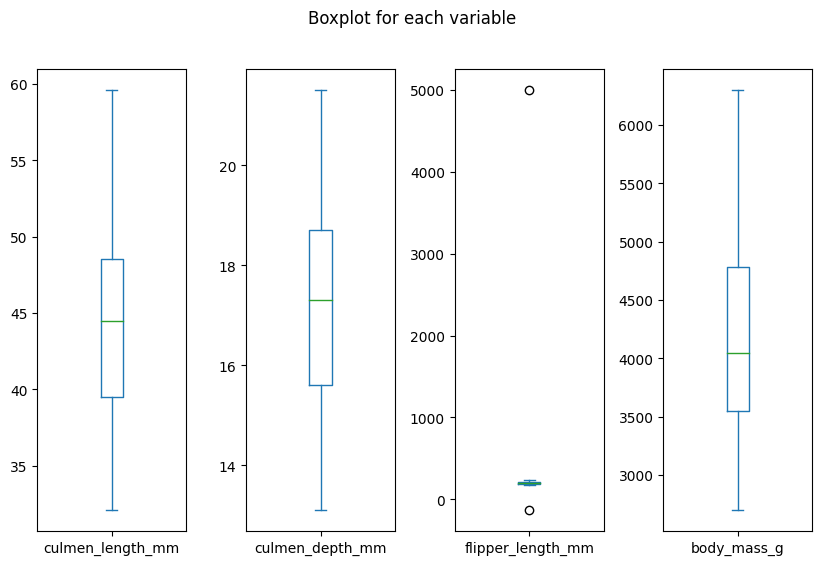

In [281]:
penguins_clean.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)
 
# increase spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.suptitle("Boxplot for each variable")
plt.show()

We can see that we have and outlier in the `flipper_length_mm` column. Let's remove it

In [282]:
import numpy as np

outlier_bot_idx = penguins_clean["flipper_length_mm"].idxmin()
outlier_up_idx = penguins_clean["flipper_length_mm"].idxmax()

print(f"Index for up outlier: {outlier_up_idx}")
print(f"Index for bot outlier: {outlier_bot_idx}")

Index for up outlier: 7
Index for bot outlier: 10


In [283]:
penguins_clean.iloc[outlier_bot_idx]

culmen_length_mm       34.6
culmen_depth_mm        21.1
flipper_length_mm    -132.0
body_mass_g          4400.0
sex                    MALE
Name: 10, dtype: object

In [284]:
# Drop indices
penguins_clean = penguins_clean.drop(
                        [outlier_bot_idx, outlier_up_idx], 
                        axis=0).reset_index(drop=True)
penguins_clean.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE
5,38.9,17.8,181.0,3625.0,FEMALE
6,39.2,19.6,195.0,4675.0,MALE
7,41.1,17.6,182.0,3200.0,FEMALE
8,38.6,21.2,191.0,3800.0,MALE
9,36.6,17.8,185.0,3700.0,FEMALE


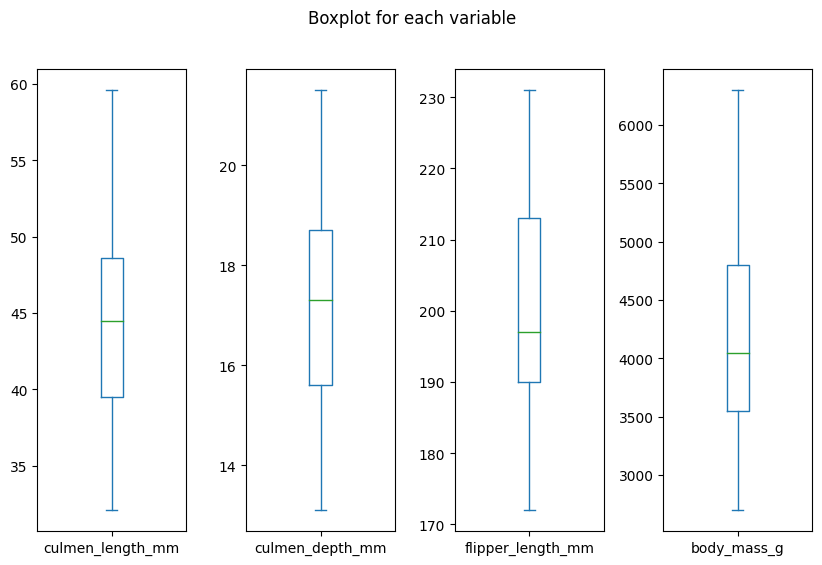

In [285]:
penguins_clean.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)
 
# increase spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.suptitle("Boxplot for each variable")
plt.show()

## Encoding categorical variables

In [286]:
penguins_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   333 non-null    float64
 1   culmen_depth_mm    333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   sex                333 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


The "sex" field is the only categorical variable in our dataset. Let's encode it using `pandas.get_dummies()` method.

In [287]:
import pandas as pd

penguins_clean = pd.get_dummies(penguins_clean, columns=["sex"],                                     drop_first=True)
penguins_clean.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
3,36.7,19.3,193.0,3450.0,1,0
4,39.3,20.6,190.0,3650.0,0,1


Using the argument `drop_first=True` we removed our original "sex" variable. We can just take one of our resulting encoding variable since they have the same information.

In [288]:
# Remove one of the resulting encoding variables.
# penguins_preprocessed = penguins_preprocessed.drop(columns=["sex_MALE"], axis=1)
# penguins_preprocessed.head()

## Scale our data
We will use the `StandardScaler` class from the `sklearn.preprocessing` module.

In [289]:
# Create scaler object
scaler = StandardScaler()

# Fit scaler with our data
scaler.fit(penguins_clean)

# Transform our data
scaled_features = scaler.transform(penguins_clean)
penguins_preprocessed = pd.DataFrame(scaled_features, 
                                     index=penguins_clean.index,
                                     columns=penguins_clean.columns)

penguins_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.905520,0.793126,-1.428125,-0.569709,-0.991031,0.997001
1,-0.831938,0.128503,-1.071522,-0.507579,1.009050,-1.003008
2,-0.684775,0.435252,-0.429637,-1.191006,1.009050,-1.003008
3,-1.347011,1.099875,-0.572278,-0.942487,1.009050,-1.003008
4,-0.868729,1.764498,-0.786240,-0.693968,-0.991031,0.997001


## Apply PCA

In [290]:
var_ratio = []
nums = (1,2,3,4)
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(penguins_preprocessed)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

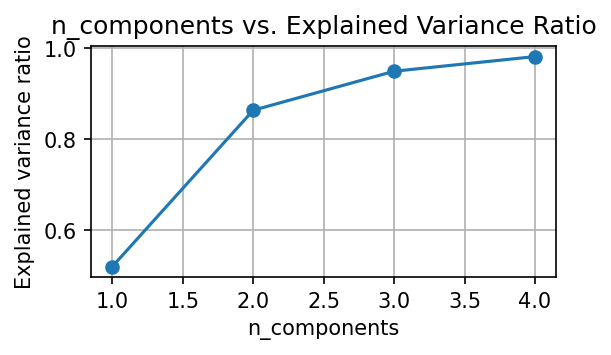

In [291]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.grid()
plt.show()

Using two components we can explain around 86% of our data.

In [292]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(penguins_preprocessed)

PCA(n_components=2)

In [293]:
penguins_PCA = pca.transform(penguins_preprocessed)

In [294]:
print(f"Explained variance using 2 components: {np.sum(pca.explained_variance_ratio_):.4f}")

Explained variance using 2 components: 0.8640


Let's visualize our data in 2D

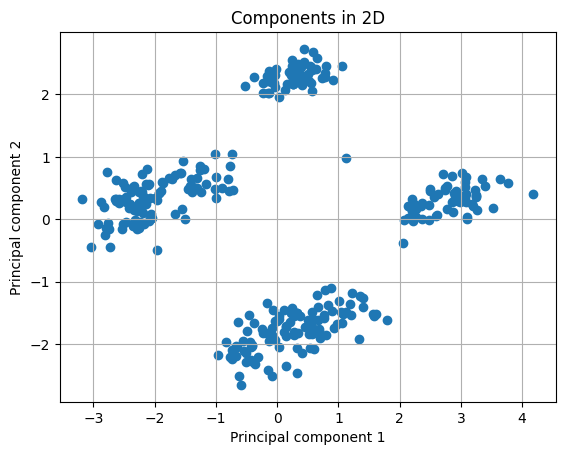

In [295]:
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Components in 2D')
plt.grid()
plt.show()


In [296]:
penguins_PCA_df = pd.DataFrame(columns=["PC1", "PC2"], data=penguins_PCA)

In [297]:
penguins_PCA_df.head()

,PC1,PC2
0,-0.729521,-2.097192
1,-1.929304,0.412150
2,-1.953525,0.308485
3,-2.288178,-0.158278
4,-0.621822,-2.514020


## Employ K-means

In [298]:
distortions = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(penguins_PCA)
    penguins_PCA_df[f"kmeans_{k}"] = model.predict(penguins_PCA)
    distortions.append(model.inertia_)

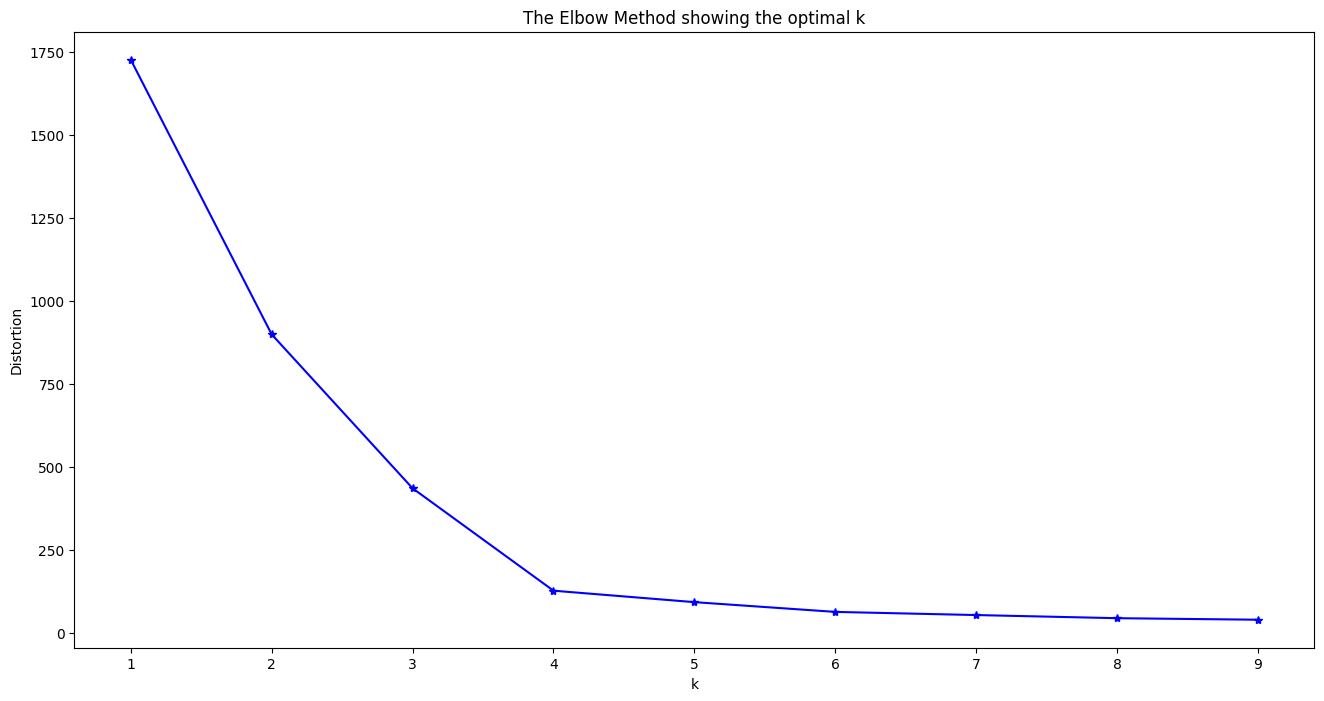

In [299]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'b*-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

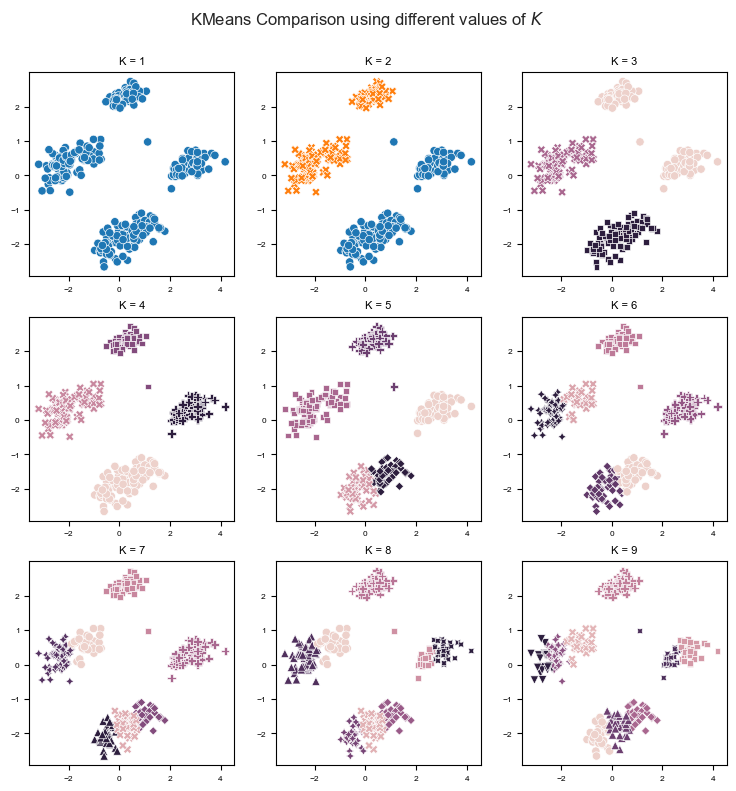

In [300]:
import seaborn as sns

fig, axes = plt.subplots(3,3, figsize=(9,9))

c = 1
PC1 = penguins_PCA_df["PC1"]
PC2 = penguins_PCA_df["PC2"]
with sns.axes_style("darkgrid"):
    for sp in axes.flatten():
        sns.scatterplot(data=penguins_PCA_df, x="PC1", y="PC2", hue=f"kmeans_{c}",style=f"kmeans_{c}", ax=sp,
                       legend=None)
        sp.set_title(f"K = {c}", fontsize=8)
        # sp.tick_params(axis="both", which="major", labelsize=6)
        sp.xaxis.set_tick_params(labelsize=6)
        sp.set_xlabel("")
        sp.set_ylabel("")
        sp.yaxis.set_tick_params(labelsize=6)
        c += 1

    plt.suptitle(r"KMeans Comparison using different values of $K$", y=0.95)
    plt.show()

Let's pick 3 clusters since we know that there are three species in this region: Adelie, Chinstrap, and Gentoo

In [301]:
n_cluster = 4

kmeans = KMeans(n_clusters=n_cluster, random_state=42)
kmeans.fit(penguins_PCA)
penguins_clean["label"] = kmeans.labels_

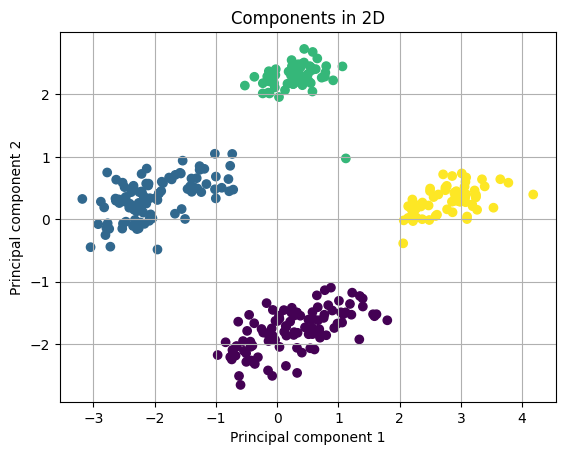

In [302]:
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=kmeans.labels_)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Components in 2D')
plt.grid()
plt.show()

In [303]:
numeric_columns = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]

In [304]:
stat_penguins = penguins_clean.groupby("label")[numeric_columns].mean()

In [305]:
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,40.217757,17.611215,189.046729,3419.158879
2,45.545763,14.262712,212.779661,4683.050847
3,49.473770,15.718033,221.540984,5484.836066


In [306]:
penguins_preprocessed.shape

(333, 6)

In [307]:
penguins_clean.shape

(333, 7)

In [308]:
penguins_preprocessed.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.905520,0.793126,-1.428125,-0.569709,-0.991031,0.997001
1,-0.831938,0.128503,-1.071522,-0.507579,1.009050,-1.003008
2,-0.684775,0.435252,-0.429637,-1.191006,1.009050,-1.003008
3,-1.347011,1.099875,-0.572278,-0.942487,1.009050,-1.003008
4,-0.868729,1.764498,-0.786240,-0.693968,-0.991031,0.997001


In [309]:
penguins_clean.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE,label
0,39.1,18.7,181.0,3750.0,0,1,0
1,39.5,17.4,186.0,3800.0,1,0,1
2,40.3,18.0,195.0,3250.0,1,0,1
3,36.7,19.3,193.0,3450.0,1,0,1
4,39.3,20.6,190.0,3650.0,0,1,0
